# **Notebook 02 — Model Training, Validation, and Interpretation**

**Project:** Predictive Archaeological Modelling — Peru  
**Objective:** Train and compare supervised classification algorithms to distinguish geospatial settlement patterns from environmental covariates.

### Workflow

1. **Configuration and data loading**
2. **Exploratory Data Analysis (EDA):** Correlation matrix and separability diagnostics.
3. **Preprocessing:** Stratified train/test split and feature scaling.
4. **Benchmark training:** Logistic Regression, Random Forest, Gradient Boosting, XGBoost.
5. **Evaluation:** ROC-AUC, confusion matrices, classification reports, cross-validation.
6. **Interpretability:** Gini importance and permutation importance.
7. **Serialization:** Export best model for spatial prediction (Notebook 03).

### **1. Environment Setup and Data Loading**

Import the libraries required for matrix computation, statistical visualization, and predictive modelling (`scikit-learn`, `xgboost`). Load the **master dataset** generated in the feature engineering phase (Notebook 01).

In [1]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 11, "figure.dpi": 120})

FIGURES_DIR = "../outputs/figures"
MODELS_DIR = "../models"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# ==============================================================================
# DATA LOADING
# ==============================================================================
ruta_dataset = "../data/features/dataset_entrenamiento.csv"

if os.path.exists(ruta_dataset):
    df = pd.read_csv(ruta_dataset)
    print(f"Dataset loaded: {df.shape[0]} rows x {df.shape[1]} columns")
    print(f"\n--- Preview ---")
    display(df.head())
    print(f"\n--- Data types ---")
    print(df.dtypes)
else:
    raise FileNotFoundError(f"Dataset not found: {ruta_dataset}")

Dataset loaded: 27223 rows x 12 columns

--- Preview ---


,X_102033,Y_102033,Origen,Target,pendiente,rugosidad,dist_rios,dist_lagos,dist_qhapaq,dist_g1,dist_g2,dist_g3
0,-1.794915e+06,2.428515e+06,Sitio_Declarado,1,2.569503,3.464102,30.00000,2731.48320,30.0000,1955.7607,0.0000,35445.734
1,-1.780363e+06,2.414741e+06,Sitio_Declarado,1,4.431820,5.830952,954.82983,60.00000,1950.2307,2640.0000,1890.9521,37885.344
2,-1.778420e+06,2.414945e+06,Sitio_Declarado,1,4.727943,6.708204,84.85281,540.83264,0.0000,630.0000,0.0000,37040.684
3,-1.791737e+06,2.426272e+06,Sitio_Declarado,1,3.372287,12.124355,90.00000,2508.00730,30.0000,2502.2588,0.0000,34444.000
4,-1.806857e+06,2.438869e+06,Sitio_Declarado,1,5.788832,8.124039,573.14920,1281.60060,0.0000,15218.7250,4797.8433,41604.332



--- Data types ---
X_102033       float64
Y_102033       float64
Origen             str
Target           int64
pendiente      float64
rugosidad      float64
dist_rios      float64
dist_lagos     float64
dist_qhapaq    float64
dist_g1        float64
dist_g2        float64
dist_g3        float64
dtype: object


### **2. Exploratory Data Analysis (EDA)**

Before training, it is essential to understand the statistical behaviour of the predictor variables.

#### **2.1 Correlation Analysis (Multicollinearity)**
**Objective:** Detect redundancy between predictors.  
*Fig. 1:* Spearman correlation heatmap. If two variables exhibit $|r_s| > 0.85$, they carry essentially the same information and one may be removed to reduce noise.

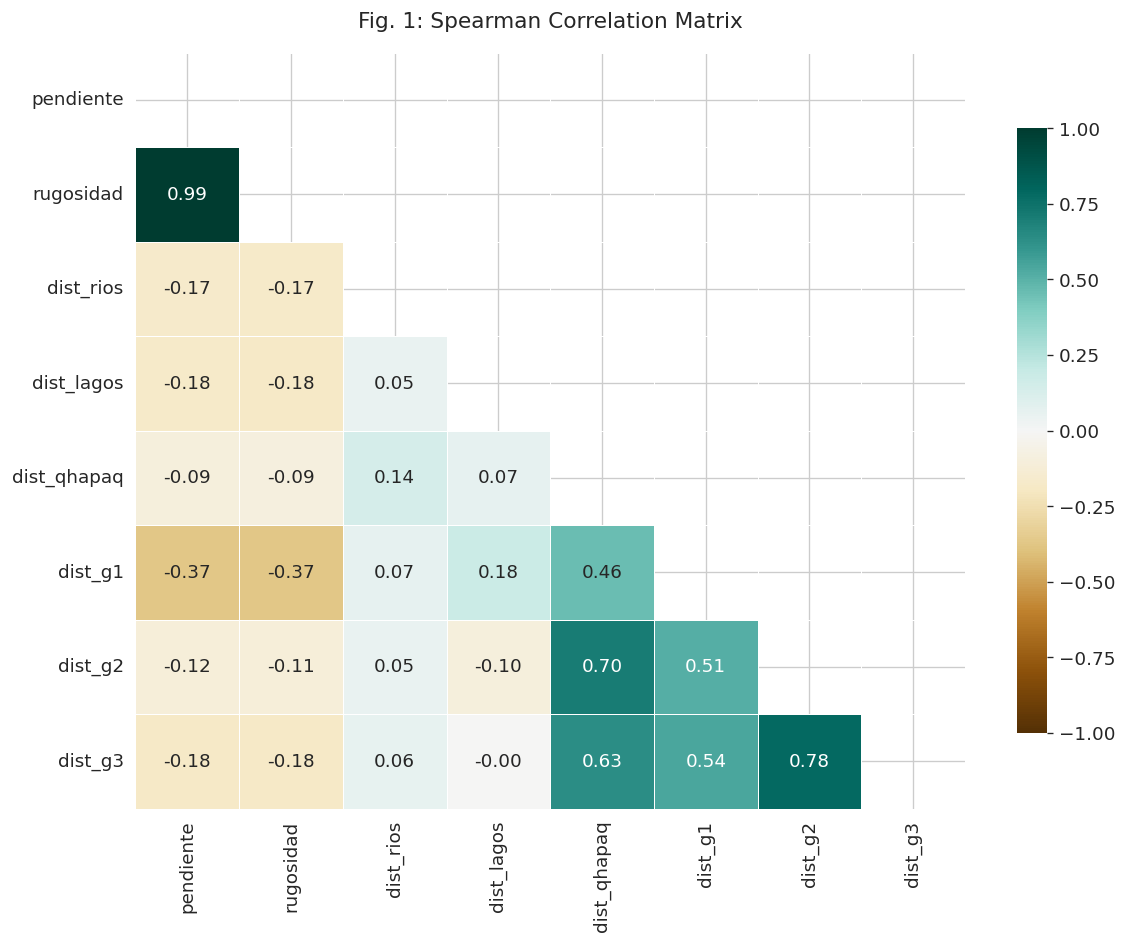

Redundancy diagnostic (|r| > 0.85):
  WARNING — Redundant variable pairs detected:
rugosidad  pendiente    0.994995
pendiente  rugosidad    0.994995
dtype: float64


In [2]:
# ==============================================================================
# FEATURE DEFINITION
# ==============================================================================
cols_features = [
    "pendiente", "rugosidad",
    "dist_rios", "dist_lagos", "dist_qhapaq",
    "dist_g1", "dist_g2", "dist_g3",
]

# ==============================================================================
# SPEARMAN CORRELATION MATRIX
# ==============================================================================
corr_matrix = df[cols_features].corr(method="spearman")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt=".2f",
    cmap="BrBG", vmin=-1, vmax=1, center=0,
    linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax,
)
ax.set_title("Fig. 1: Spearman Correlation Matrix", fontsize=13, pad=15)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_correlation_matrix.png"), dpi=150, bbox_inches="tight")
plt.show()

# Automated redundancy diagnostic
print("Redundancy diagnostic (|r| > 0.85):")
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1.0]
pairs = high_corr[high_corr > 0.85]

if len(pairs) > 0:
    print(f"  WARNING — Redundant variable pairs detected:\n{pairs}")
else:
    print("  No severe multicollinearity (all |r| < 0.85).")

In [3]:
# ==============================================================================
# DATA CLEANING
# ==============================================================================
df["Target"] = df["Target"].astype(int)

# Conditionally remove rugosidad if highly correlated with pendiente
if "rugosidad" in df.columns:
    r = df[["pendiente", "rugosidad"]].corr(method="spearman").iloc[0, 1]
    if abs(r) > 0.90:
        df = df.drop(columns=["rugosidad"])
        cols_features = [c for c in cols_features if c != "rugosidad"]
        print(f"Variable 'rugosidad' removed (Spearman r = {r:.3f} with 'pendiente').")
    else:
        print(f"Variable 'rugosidad' retained (Spearman r = {r:.3f}).")

print(f"Final features ({len(cols_features)}): {cols_features}")

Variable 'rugosidad' removed (Spearman r = 0.995 with 'pendiente').
Final features (7): ['pendiente', 'dist_rios', 'dist_lagos', 'dist_qhapaq', 'dist_g1', 'dist_g2', 'dist_g3']


#### **2.2 Separability Analysis (Boxplots)**
**Objective:** Visually assess the discriminative power of each variable.  
*Fig. 2:* Comparative boxplots. Variables where the distribution of sites ($Y=1$) is visibly distinct from absences ($Y=0$) are expected to contribute most to classification.

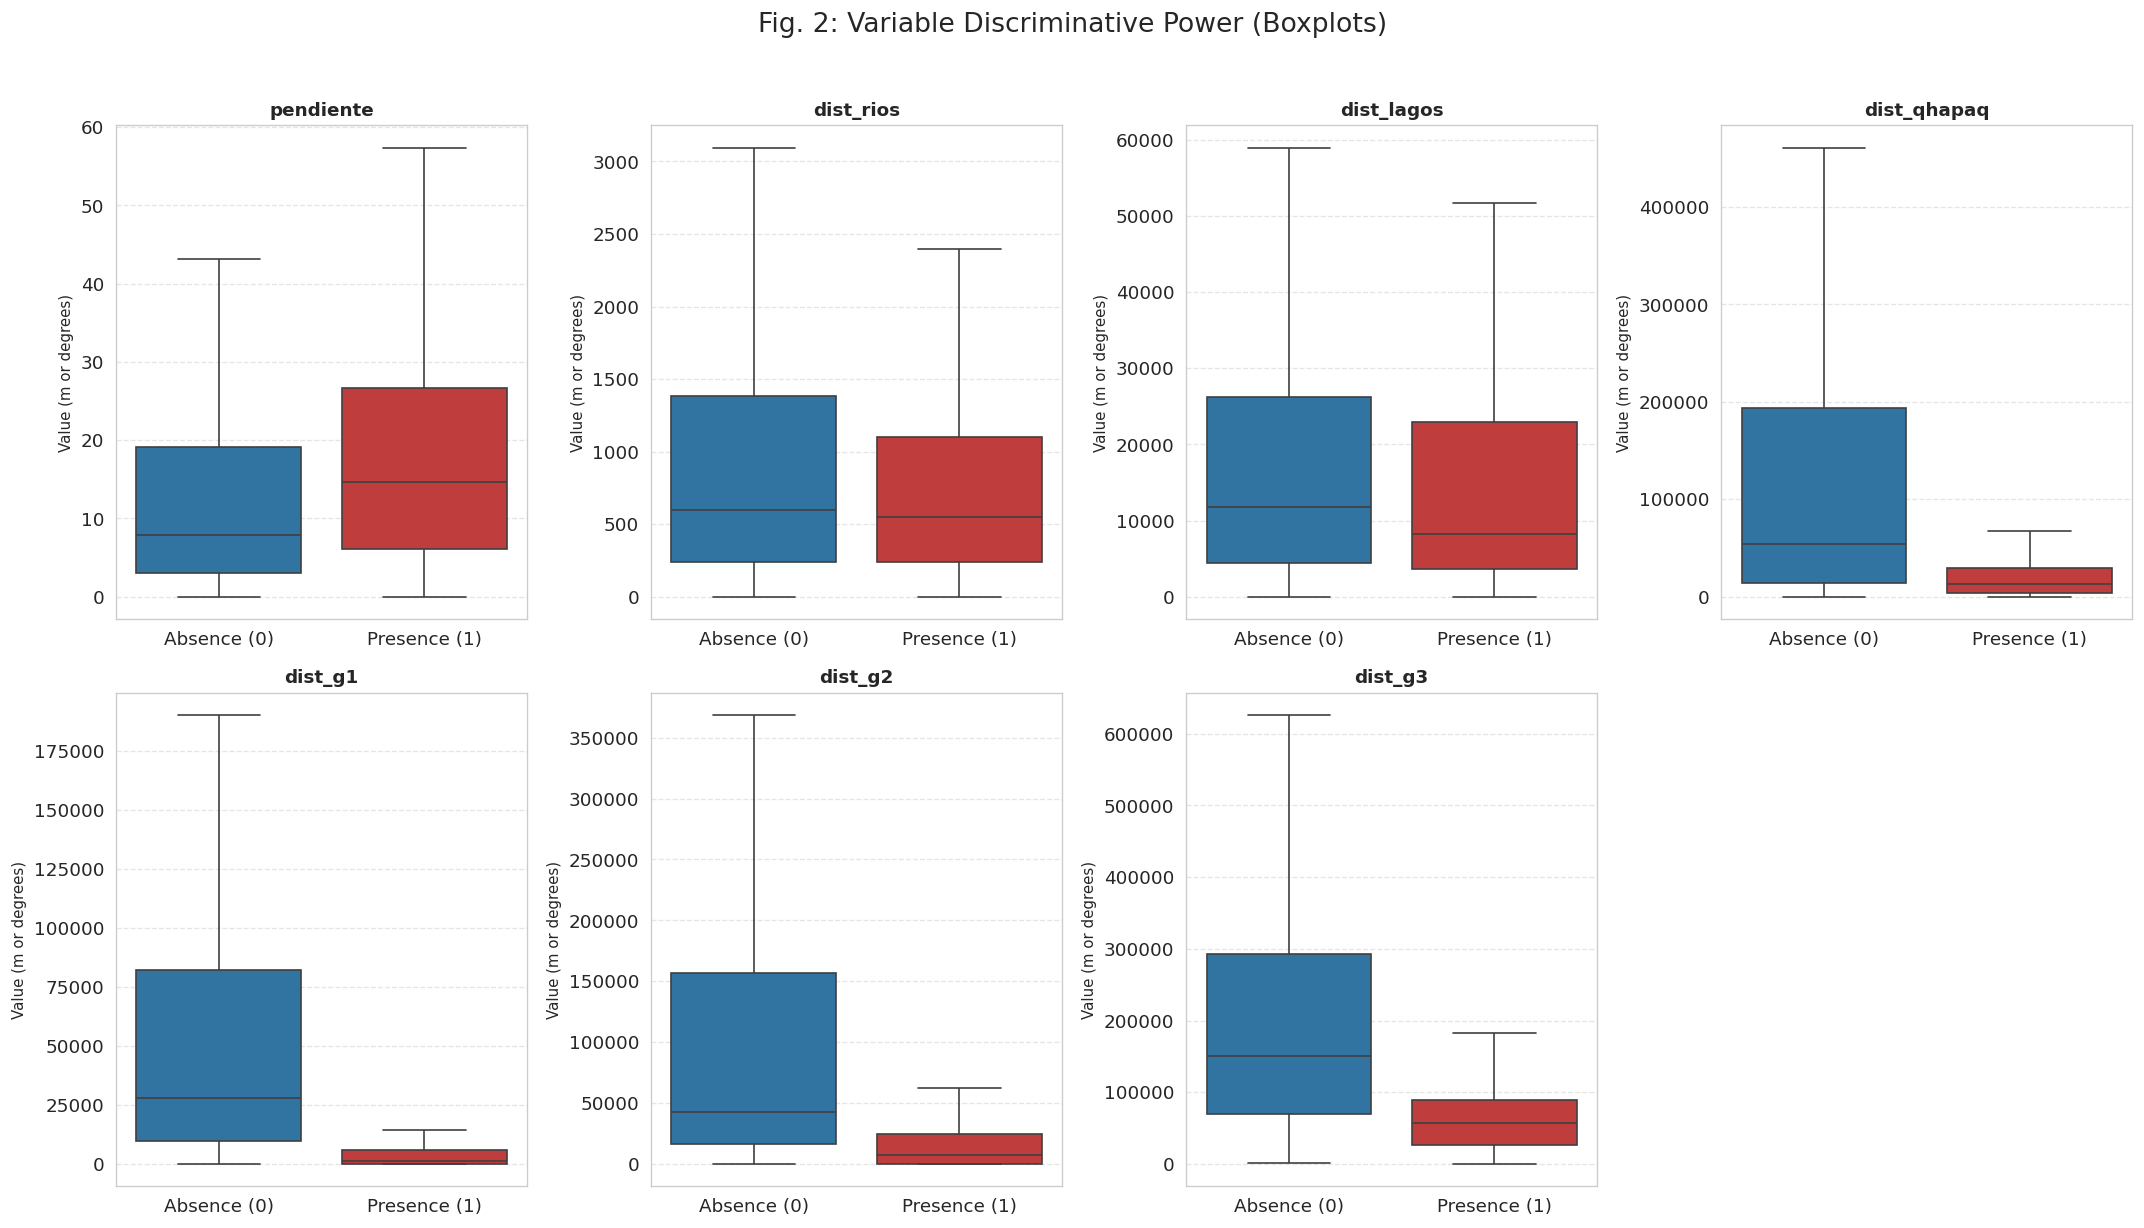

In [4]:
# ==============================================================================
# SEPARABILITY ANALYSIS (Boxplots)
# ==============================================================================
n_vars = len(cols_features)
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

palette = {0: "#1f77b4", 1: "#d62728"}

for i, col in enumerate(cols_features):
    sns.boxplot(
        x="Target", y=col, data=df, ax=axes[i],
        palette=palette, hue="Target", legend=False, showfliers=False,
    )
    axes[i].set_title(col, fontweight="bold", fontsize=11)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Value (m or degrees)", fontsize=9)
    axes[i].set_xticklabels(["Absence (0)", "Presence (1)"])
    axes[i].grid(True, axis="y", linestyle="--", alpha=0.5)

for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Fig. 2: Variable Discriminative Power (Boxplots)", fontsize=16, y=1.02)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_boxplots.png"), dpi=150, bbox_inches="tight")
plt.show()

### **3. Preprocessing and Data Partitioning**

To ensure scientific validity and prevent overfitting, a strict data-splitting protocol is applied:

* **Stratified Split:** The dataset is divided into **Training (70%)** and **Test (30%)**, preserving the original class ratio in both subsets.
* **Feature Scaling:** Variables are standardized ($\mu=0, \sigma=1$) for models sensitive to magnitude (Logistic Regression). Tree-based models receive unscaled features.

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# FEATURE / TARGET MATRICES
# ==============================================================================
X = df[cols_features]
y = df["Target"]

print(f"Features (X): {X.shape}")
print(f"Target (y):   {y.shape} — class balance: {y.value_counts().to_dict()}")

# ==============================================================================
# STRATIFIED SPLIT (70 / 30)
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# ==============================================================================
# STANDARD SCALING
# ==============================================================================
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=cols_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=cols_features)

print("\nScaled features (first 3 rows):")
display(X_train_scaled.head(3))

Features (X): (27223, 7)
Target (y):   (27223,) — class balance: {1: 14627, 0: 12596}

Train: 19056 samples
Test:  8167 samples

Scaled features (first 3 rows):


,pendiente,dist_rios,dist_lagos,dist_qhapaq,dist_g1,dist_g2,dist_g3
0,-0.828485,-0.590869,-0.454922,-0.483005,-0.405019,-0.289396,-0.366219
1,-1.021166,2.703088,-0.924000,-0.412956,-0.521370,-0.340507,0.375131
2,-0.663813,1.212336,2.625607,-0.439052,-0.356660,-0.577782,-0.675276


### **4. Model Training (Benchmark)**

Four algorithms of different nature are trained and compared to identify the most robust classifier for this archaeological domain:

1. **Logistic Regression (Baseline):** Linear model. Lower-bound reference for comparison.
2. **Random Forest (Bagging):** Decision-tree ensemble, robust to noise, does not require feature scaling.
3. **Gradient Boosting (sklearn — Boosting):** Sequential tree ensemble with shrinkage regularization.
4. **XGBoost (Optimized Boosting):** State-of-the-art for tabular data. Regularized gradient boosting with parallel tree construction.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

print("--- Model Training ---")

modelos = {}

# 1. Logistic Regression (uses scaled data)
print("\n  [1/4] Logistic Regression ...")
t0 = time.time()
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
modelos["Logistic Regression"] = {"model": log_reg, "scaled": True}
print(f"        Done in {time.time() - t0:.2f} s")

# 2. Random Forest (uses raw data)
print("  [2/4] Random Forest ...")
t0 = time.time()
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
modelos["Random Forest"] = {"model": rf_model, "scaled": False}
print(f"        Done in {time.time() - t0:.2f} s")

# 3. Gradient Boosting (uses raw data)
print("  [3/4] Gradient Boosting ...")
t0 = time.time()
gb_model = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
)
gb_model.fit(X_train, y_train)
modelos["Gradient Boosting"] = {"model": gb_model, "scaled": False}
print(f"        Done in {time.time() - t0:.2f} s")

# 4. XGBoost (uses raw data)
print("  [4/4] XGBoost ...")
t0 = time.time()
xgb_model = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=5,
    use_label_encoder=False, eval_metric="logloss",
    random_state=42, n_jobs=-1,
)
xgb_model.fit(X_train, y_train)
modelos["XGBoost"] = {"model": xgb_model, "scaled": False}
print(f"        Done in {time.time() - t0:.2f} s")

print("\nAll 4 models trained.")

--- Model Training ---

  [1/4] Logistic Regression ...
        Done in 0.07 s
  [2/4] Random Forest ...
        Done in 0.73 s
  [3/4] Gradient Boosting ...
        Done in 9.43 s
  [4/4] XGBoost ...
        Done in 2.45 s

All 4 models trained.


### **5. Performance Evaluation**

Objective metrics are used to quantify prediction reliability on the held-out test set (data unseen during training).

#### **5.1 ROC Curves and Global Accuracy**
*Fig. 3:* Receiver Operating Characteristic curves.
* **Metric:** AUC (Area Under Curve). A value of 0.5 equals random chance; 1.0 is perfect discrimination. In archaeological predictive modelling, AUC $> 0.80$ is considered excellent.

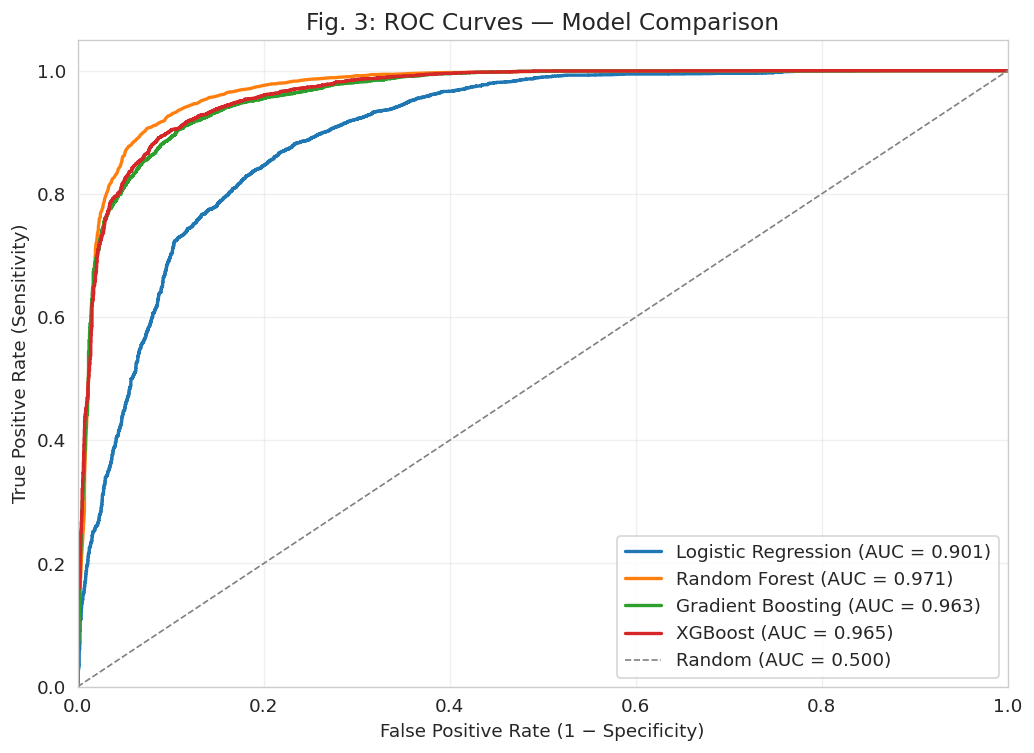

In [7]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# ==============================================================================
# ROC CURVES
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 7))

resultados = {}

for nombre, info in modelos.items():
    modelo = info["model"]
    X_eval = X_test_scaled if info["scaled"] else X_test

    y_prob = modelo.predict_proba(X_eval)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    resultados[nombre] = {"AUC": roc_auc, "X_eval": X_eval, "y_prob": y_prob}
    ax.plot(fpr, tpr, lw=2, label=f"{nombre} (AUC = {roc_auc:.3f})")

ax.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--", label="Random (AUC = 0.500)")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate (1 − Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity)")
ax.set_title("Fig. 3: ROC Curves — Model Comparison", fontsize=14)
ax.legend(loc="lower right")
ax.grid(alpha=0.3)

fig.savefig(os.path.join(FIGURES_DIR, "fig_roc_curves.png"), dpi=150, bbox_inches="tight")
plt.show()

#### **5.2 Confusion Matrices**
*Fig. 4:* Heatmaps of correct and incorrect predictions.
* **Analysis:** In the archaeological context, minimizing **False Negatives** (failing to detect an existing site) is critical. This is captured by the **Recall (Sensitivity)** metric.

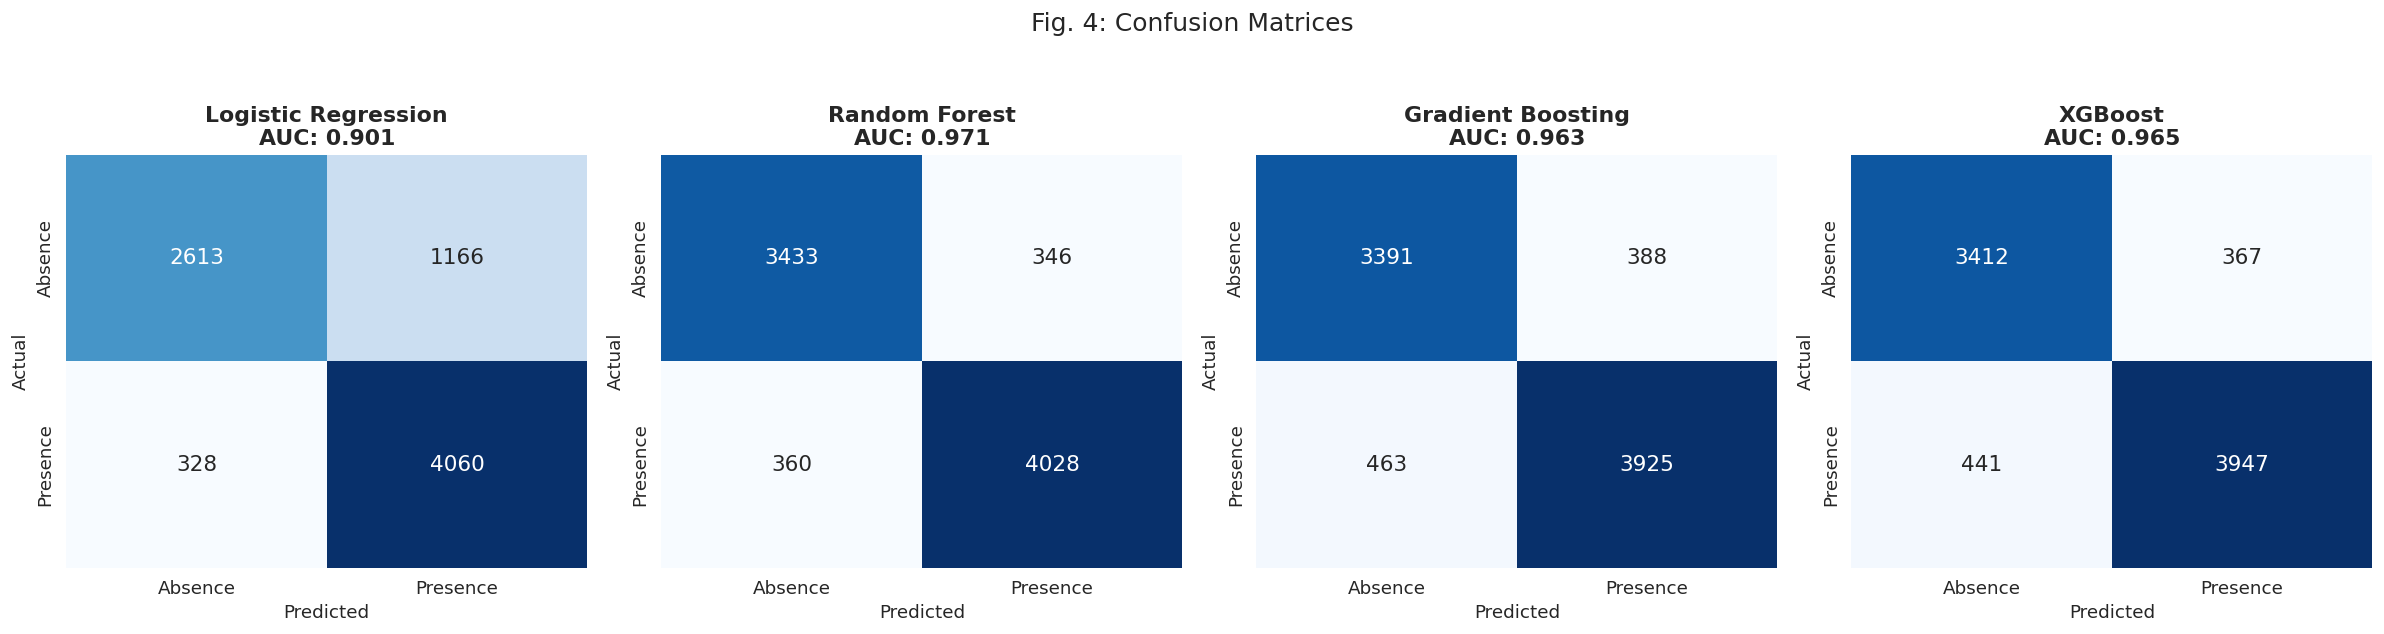

--- Classification Reports ---
Best model by AUC: RANDOM FOREST

--- Logistic Regression ---
              precision    recall  f1-score   support

     Absence       0.89      0.69      0.78      3779
    Presence       0.78      0.93      0.84      4388

    accuracy                           0.82      8167
   macro avg       0.83      0.81      0.81      8167
weighted avg       0.83      0.82      0.81      8167

--- Random Forest ---
              precision    recall  f1-score   support

     Absence       0.91      0.91      0.91      3779
    Presence       0.92      0.92      0.92      4388

    accuracy                           0.91      8167
   macro avg       0.91      0.91      0.91      8167
weighted avg       0.91      0.91      0.91      8167

--- Gradient Boosting ---
              precision    recall  f1-score   support

     Absence       0.88      0.90      0.89      3779
    Presence       0.91      0.89      0.90      4388

    accuracy                           0.

In [8]:
# ==============================================================================
# CONFUSION MATRICES
# ==============================================================================
n_models = len(modelos)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))

for i, (nombre, info) in enumerate(modelos.items()):
    X_eval = resultados[nombre]["X_eval"]
    y_pred = info["model"].predict(X_eval)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                ax=axes[i], annot_kws={"size": 13})
    axes[i].set_title(f"{nombre}\nAUC: {resultados[nombre]['AUC']:.3f}", fontweight="bold")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].set_xticklabels(["Absence", "Presence"])
    axes[i].set_yticklabels(["Absence", "Presence"])

fig.suptitle("Fig. 4: Confusion Matrices", fontsize=15, y=1.05)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, "fig_confusion_matrices.png"), dpi=150, bbox_inches="tight")
plt.show()

# Classification reports
print("--- Classification Reports ---")
best_name = max(resultados, key=lambda x: resultados[x]["AUC"])
print(f"Best model by AUC: {best_name.upper()}\n")

for nombre, info in modelos.items():
    X_eval = resultados[nombre]["X_eval"]
    y_pred = info["model"].predict(X_eval)
    print(f"--- {nombre} ---")
    print(classification_report(y_test, y_pred, target_names=["Absence", "Presence"]))

### **5.3 Cross-Validation (5-Fold Stratified)**

To assess generalization stability beyond a single train/test split, we compute ROC-AUC over 5 stratified folds. This provides a mean performance estimate with standard deviation, which is more robust for reporting in scientific publications.

In [9]:
# ==============================================================================
# CROSS-VALIDATION (5-Fold Stratified)
# ==============================================================================
print("--- 5-Fold Stratified Cross-Validation (ROC-AUC) ---\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for nombre, info in modelos.items():
    modelo = info["model"]
    X_cv = pd.DataFrame(scaler.transform(X), columns=cols_features) if info["scaled"] else X
    scores = cross_val_score(modelo, X_cv, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    cv_results.append({
        "Model": nombre,
        "AUC_mean": scores.mean(),
        "AUC_std": scores.std(),
    })
    print(f"  {nombre:25s} | AUC = {scores.mean():.4f} +/- {scores.std():.4f}")

df_cv = pd.DataFrame(cv_results).sort_values("AUC_mean", ascending=False)
print("\n--- Summary ---")
display(df_cv)

--- 5-Fold Stratified Cross-Validation (ROC-AUC) ---

  Logistic Regression       | AUC = 0.8993 +/- 0.0037
  Random Forest             | AUC = 0.9725 +/- 0.0018
  Gradient Boosting         | AUC = 0.9644 +/- 0.0025
  XGBoost                   | AUC = 0.9663 +/- 0.0026

--- Summary ---


,Model,AUC_mean,AUC_std
1,Random Forest,0.972522,0.001759
3,XGBoost,0.966255,0.002600
2,Gradient Boosting,0.964418,0.002496
0,Logistic Regression,0.899287,0.003678


### **6. Feature Importance (Interpretability)**

**Gini Importance (MDI):** Measures how much each feature contributes to reducing impurity across all trees. Fast but can be biased toward high-cardinality features.

**Permutation Importance:** Model-agnostic method that measures the decrease in performance when each feature is randomly shuffled. More reliable for correlated predictors.

--- Feature Importance: Random Forest ---



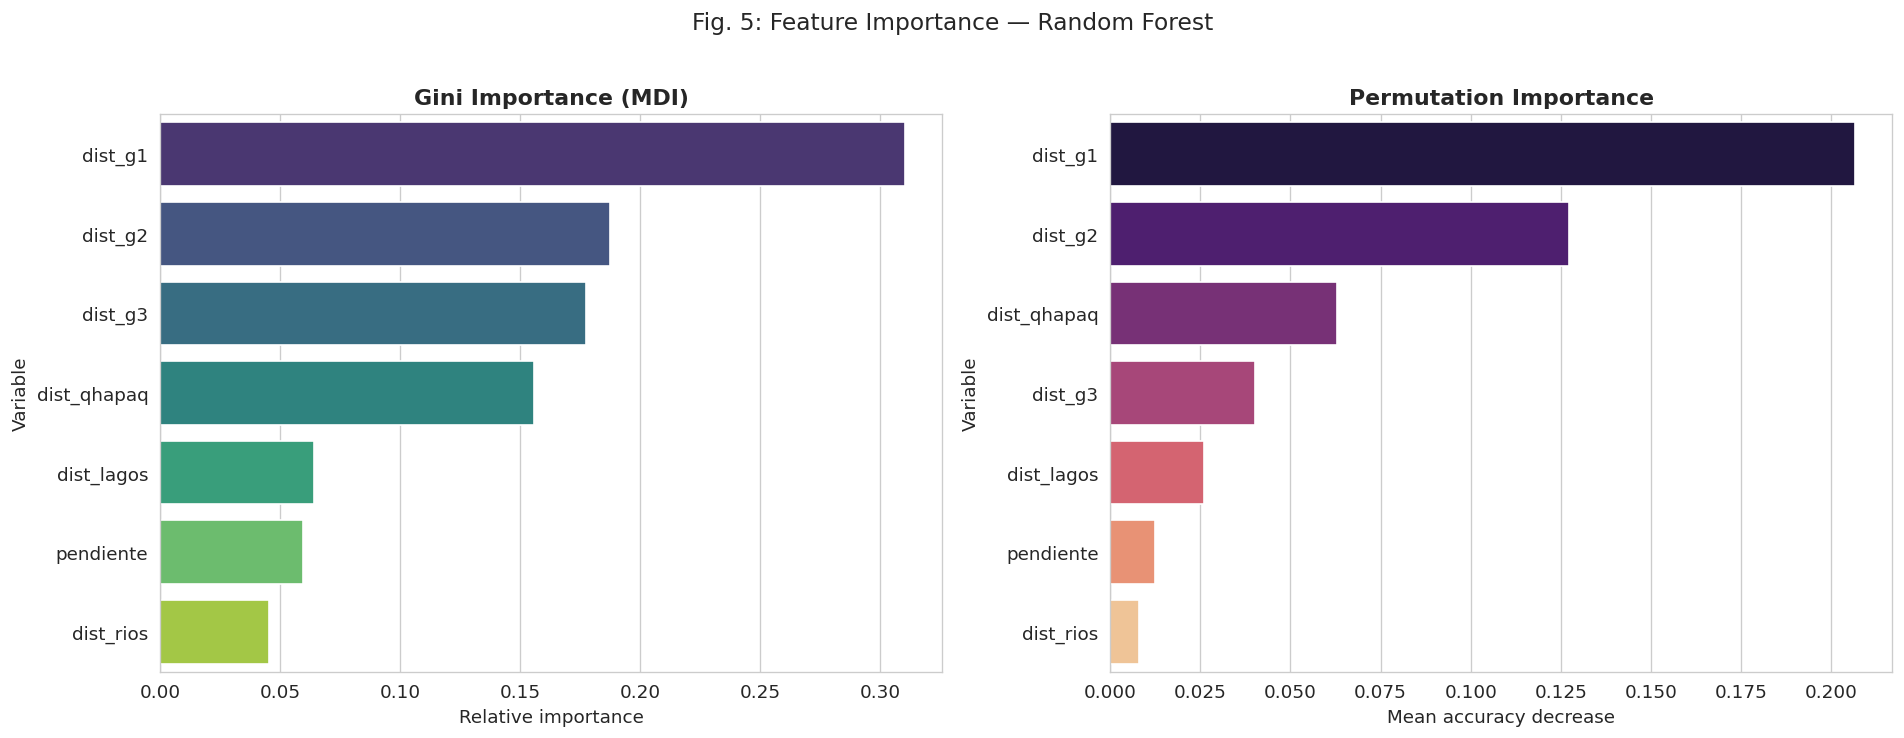

Gini ranking:


,Variable,Gini Importance
4,dist_g1,0.310337
5,dist_g2,0.187560
6,dist_g3,0.177506
3,dist_qhapaq,0.155830
2,dist_lagos,0.064169
0,pendiente,0.059421
1,dist_rios,0.045176



Permutation ranking:


,Variable,Permutation Importance,Std
4,dist_g1,0.206575,0.003753
5,dist_g2,0.127317,0.004194
3,dist_qhapaq,0.062899,0.002303
6,dist_g3,0.040162,0.002201
2,dist_lagos,0.025958,0.001423
0,pendiente,0.012428,0.001921
1,dist_rios,0.008094,0.000884


In [10]:
from sklearn.inspection import permutation_importance

# ==============================================================================
# FEATURE IMPORTANCE (Gini + Permutation)
# ==============================================================================
best_model_name = max(resultados, key=lambda x: resultados[x]["AUC"])
best_info = modelos[best_model_name]
best_model = best_info["model"]
X_eval_best = resultados[best_model_name]["X_eval"]

print(f"--- Feature Importance: {best_model_name} ---\n")

if hasattr(best_model, "feature_importances_"):
    # 1. Gini importance
    gini_imp = pd.DataFrame({
        "Variable": cols_features,
        "Gini Importance": best_model.feature_importances_,
    }).sort_values("Gini Importance", ascending=False)

    # 2. Permutation importance
    perm_result = permutation_importance(
        best_model, X_eval_best, y_test,
        n_repeats=10, random_state=42, n_jobs=-1,
    )
    perm_imp = pd.DataFrame({
        "Variable": cols_features,
        "Permutation Importance": perm_result.importances_mean,
        "Std": perm_result.importances_std,
    }).sort_values("Permutation Importance", ascending=False)

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(x="Gini Importance", y="Variable", data=gini_imp,
                palette="viridis", ax=axes[0])
    axes[0].set_title("Gini Importance (MDI)", fontweight="bold")
    axes[0].set_xlabel("Relative importance")

    sns.barplot(x="Permutation Importance", y="Variable", data=perm_imp,
                palette="magma", ax=axes[1])
    axes[1].set_title("Permutation Importance", fontweight="bold")
    axes[1].set_xlabel("Mean accuracy decrease")

    fig.suptitle(f"Fig. 5: Feature Importance — {best_model_name}", fontsize=14, y=1.02)
    plt.tight_layout()
    fig.savefig(os.path.join(FIGURES_DIR, "fig_feature_importance.png"), dpi=150, bbox_inches="tight")
    plt.show()

    print("Gini ranking:")
    display(gini_imp)
    print("\nPermutation ranking:")
    display(perm_imp)
else:
    print("Selected model does not expose feature_importances_.")

### **7. Model Serialization**

The best-performing model and the fitted scaler are serialized for reuse in Notebook 03 (spatial prediction and heatmap generation).

In [11]:
import joblib

# ==============================================================================
# MODEL SERIALIZATION
# ==============================================================================
print("--- Saving Models ---")

best_name_clean = best_model_name.lower().replace(" ", "_")
ruta_modelo = os.path.join(MODELS_DIR, f"modelo_{best_name_clean}_final.pkl")
ruta_scaler = os.path.join(MODELS_DIR, "scaler_entrenamiento.pkl")

joblib.dump(best_model, ruta_modelo)
joblib.dump(scaler, ruta_scaler)

print(f"  Model saved:  {ruta_modelo}")
print(f"  Scaler saved: {ruta_scaler}")
print(f"\n  Ready for Notebook 03 (Prediction & Mapping).")

--- Saving Models ---
  Model saved:  ../models/modelo_random_forest_final.pkl
  Scaler saved: ../models/scaler_entrenamiento.pkl

  Ready for Notebook 03 (Prediction & Mapping).
